In [1]:
%pylab nbagg
from tvb.simulator.lab import *

Populating the interactive namespace from numpy and matplotlib
   INFO  NumExpr defaulting to 8 threads.
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'y1': array([-20.,   2.]), 'z': array([2., 5.]), 'x2': array([-2.,  0.]), 'y2': array([0., 2.]), 'g': array([-1.,  1.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.epileptor.Epileptor2D.tt = NArray(label='tt', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor2D.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'z': array([2., 5.])}, required=True)
WARNING 

WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.stefanescu_jirsa.ReducedSetFitzHughNagumo.state_variable_range = Final(field_type=<class 'dict'>, default={'xi': array([-4.,  4.]), 'eta': array([-3.,  3.]), 'alpha': array([-4.,  4.]), 'beta': array([-3.,  3.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.a = NArray(label=':math:`a`', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 3.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.b = NArray(label=':math:`b`', dtype=float64, default=array([3.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindma

# Simulate cortical surface with s/M/EEG forward solutions

Cortical surface with subcortical regions, sEEG, EEG & MEG, using a stochastic
integration.

In [2]:
from tvb.datatypes.cortex import Cortex
from tvb.datatypes.region_mapping import RegionMapping
from tvb.datatypes.surfaces import Surface
from tvb.datatypes.projections import ProjectionMatrix, ProjectionSurfaceEEG
from tvb.datatypes.sensors import SensorsEEG

oscillator = models.Generic2dOscillator(a=numpy.array([0.1]), tau=numpy.array([2.0]))

white_matter = connectivity.Connectivity.from_file('connectivity_192.zip')
white_matter.speed = numpy.array([4.0])
white_matter_coupling = coupling.Difference(a=numpy.array([0.014]))

rm = RegionMapping.from_file('regionMapping_16k_192.txt')
sensorsEEG = SensorsEEG.from_file('eeg_unitvector_62.txt.bz2')
prEEG = ProjectionSurfaceEEG.from_file('projection_eeg_62_surface_16k.mat', matlab_data_name="ProjectionMatrix")

heunint = integrators.HeunStochastic(
    dt=2**-4,
    noise=noise.Additive(nsig=numpy.array([2 ** -5, ]))
)

fsamp = 1e3/1024.0 # 1024 Hz
# See shown here 3 different ways of configuring monitors.
# These methods are available for all projection monitors
monitor_MEG=monitors.MEG.from_file()
monitor_MEG.period=fsamp
mons = (
    monitors.EEG(sensors=sensorsEEG, projection=prEEG, region_mapping=rm, period=fsamp),
    monitor_MEG,
    monitors.iEEG.from_file('seeg_588.txt', 'projection_seeg_588_surface_16k.npy', period=fsamp),
    monitors.ProgressLogger(period=100.0),
)

local_coupling_strength = numpy.array([2 ** -10])
region_mapping_data=RegionMapping.from_file('regionMapping_16k_192.txt')
region_mapping_data.surface=Surface.from_file() 
default_cortex = Cortex.from_file()
default_cortex.region_mapping_data = region_mapping_data
default_cortex.coupling_strength = local_coupling_strength

sim = simulator.Simulator(
    model=oscillator,
    connectivity=white_matter,
    coupling=white_matter_coupling,
    integrator=heunint,
    monitors=mons,
    surface=default_cortex,
    simulation_length=1000.0
).configure()

eeg, meg, seeg, _ = sim.run()

WARNING  File 'hemispheres' not found in ZIP.
   INFO  Projection configured gain shape (62, 16500)
   INFO  Projection configured gain shape (276, 16500)
   INFO  Projection configured gain shape (588, 16500)
WARNING  Memory estimate exceeds total available RAM.


c:\users\gabriel.florea\desktop\mywork\tvb_nest\tvb-root\scientific_library\tvb\simulator\monitors.py:681: RuntimeWarning: invalid value encountered in true_divide
  sensor_locations = sensor_locations / sen_dis[:, numpy.newaxis]
c:\users\gabriel.florea\desktop\mywork\tvb_nest\tvb-root\scientific_library\tvb\simulator\monitors.py:696: RuntimeWarning: divide by zero encountered in true_divide
  B_r[sensor_k, :] = ((mu_0 / (4.0 * numpy.pi * F**2)) *
c:\users\gabriel.florea\desktop\mywork\tvb_nest\tvb-root\scientific_library\tvb\simulator\monitors.py:698: RuntimeWarning: invalid value encountered in multiply
  (rsk * delF), axis=1)[:, numpy.newaxis]))


   INFO  step 1 time 0.0001 s
   INFO  step 1601 time 0.1001 s
   INFO  step 3201 time 0.2001 s
   INFO  step 4801 time 0.3001 s
   INFO  step 6401 time 0.4001 s
   INFO  step 8001 time 0.5001 s
   INFO  step 9601 time 0.6001 s
   INFO  step 11201 time 0.7001 s
   INFO  step 12801 time 0.8001 s
   INFO  step 14401 time 0.9001 s


<IPython.core.display.Javascript object>


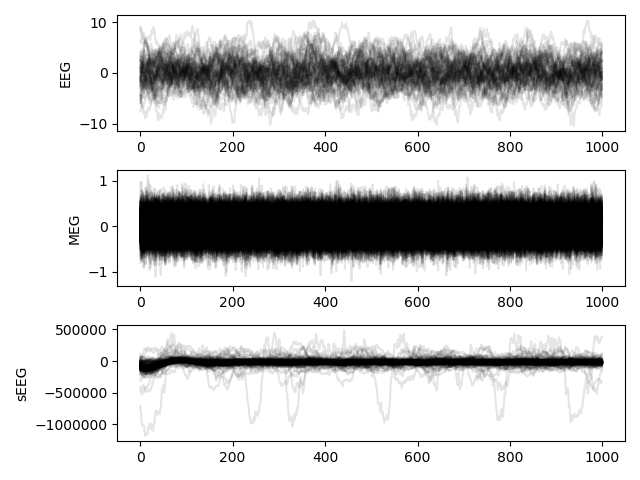

In [3]:
figure()

for i, mon in enumerate((eeg, meg, seeg)):
    subplot(3, 1, i + 1)
    time, data = mon
    plot(time, data[:, 0, :, 0], 'k', alpha=0.1)
    ylabel(['EEG', 'MEG', 'sEEG'][i])

tight_layout()